In [2]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
import ast

from langchain import PromptTemplate
from langchain.chains import SequentialChain
from langchain.chains import LLMChain

In [3]:
model = 'qwen-qwq-32b'

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
story_memory = ConversationBufferMemory(
    input_key="messages",        
    memory_key="chat_history",   
    return_messages=False
)

llm = ChatGroq(model=model)

/var/folders/8l/zl99_gy92mg5qxxvz9x0knw00000gn/T/ipykernel_16674/3306744882.py:1: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  story_memory = ConversationBufferMemory(


In [9]:
from typing_extensions import TypedDict
from typing import Annotated

class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

In [6]:
chapter_template = """
Template for Story Creation with Agentic AI

Objective:
You are a vital component of Agentic AI, designed to assist users in creating engaging stories.

Remeber : 
The plot of story and chapter should be UNIQUE and more more natural.

Your Role:
- Develop chapter titles based on the user's input.
- Generate story content upon user requests, aligning with the specified chapters.

Your Mission:
Upon receiving this prompt, consider it the beginning of a new story. Your primary task is to create compelling story chapters based on the user input provided below:

{messages}

Now, it's time to generate chapter titles for the story. Ensure they align with the specified plot of the story 
{plot} and adhere to the maximum number of chapters ({max_chapters}).

Your return type (json) :
{chapter_response_formate}

STRRICT RULE : NO EXTRA WORDS RATHER THAN CHAPTERS
"""

chapter_response_formate = '''
    {
        Story_Name : " ",
        Chapters : {
            chapter_number : chapter name,
            .....
        }
    }
'''

In [24]:
def encode_dict(plot, max_chapters) -> str:
    return str( {'plot': plot , 'max_chapters':max_chapters} )

def decode_dict(mesg):

    decode = ast.literal_eval(mesg)
    plot = decode['plot']
    max_chapters = decode['max_chapters']

    return plot, max_chapters


In [25]:
input_template = PromptTemplate(
    input_variables = ['messages','plot' , 'max_chapters', 'chapter_response_formate'],
    template = chapter_template
)

In [26]:
chain = LLMChain(
    llm = llm,
    prompt = input_template,

)

In [ ]:
res = chain.invoke({
    'messages' : [],
    'plot' : plot,
    'max_chapters': max_chapters,
    'chapter_response_formate': chapter_response_formate
})

APIConnectionError: Connection error.

Failed to get info from https://api.smith.langchain.com: LangSmithConnectionError('Connection error caused failure to GET /info in LangSmith API. Please confirm your internet connection. ConnectionError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /info (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x10c1737d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"))\nContent-Length: None\nAPI Key: lsv2_********************************************53')
Failed to batch ingest runs: langsmith.utils.LangSmithConnectionError: Connection error caused failure to POST https://api.smith.langchain.com/runs/batch in LangSmith API. Please confirm your internet connection. ConnectionError(MaxRetryError("HTTPSConnectionPool(host='api.smith.langchain.com', port=443): Max retries exceeded with url: /runs/batch (Caused by NewConnectionError('<urllib3.connection.H

In [ ]:
print(res['text'])


<think>
Okay, let's tackle this query step by step. The user wants a story about a group of friends stuck in a forest loop where they die every 65.7 hours. The chapters need to be unique and natural, with up to 12 chapters.

First, I need to understand the key elements here. The main points are the friends being trapped in a time loop, the 65.7-hour cycle, and the need to solve a puzzle to escape. The title should reflect the loop and urgency. Maybe something like "The Loop of 65.7" or "Cycle of the Forgotten Woods"?

Now, the chapters. Let me break down the possible plot progression. Start with their arrival in the forest, initial discovery of the loop. Then each chapter can explore their attempts to solve the mystery, encounters with clues, conflicts among the group, and the countdown. The 65.7-hour timeframe suggests precise timing, so maybe each chapter marks a cycle or a key discovery related to the time.

Chapter 1: Introduce the characters getting lost. Maybe "The Unseen Path" 

In [12]:
def chapter_and_story_maker(state : State) -> State:
    '''
    WARNING :::::::  THIS TOOL IS ONLY CALLED FOR ONCE WHEN THEIR IS PLOT DEFINED IN THE TEXT :::::::
    This tool is for making chapters as per the user request. When user ask for story making as per they request , then tool should
    be called and retrun the results
    '''

    print("Calling Chapter and Story Maker")

    # Decoding plot and max_chapters
    last_message = state['messages'][-1].content

    plot , max_chapters = decode_dict(last_message)
    

    # LLM Calling 
    response = chain.invoke({
        'messages' : state['messages'],
        'plot' : plot,
        'max_chapters' : max_chapters,
        'chapter_response_formate' : chapter_response_formate
    })

    with open('output.txt','a') as fp:
        fp.write(response['text'])

    print(response['text'])

    return response['text'] + "Once you got response End."

In [ ]:
state1 = State()
state1['messages'] = [HumanMessage("Lets Start")]

In [ ]:
plot = "A group of friends stuck in forest and they found that they stuck in a loop," \
" if they dont find way out they each will die on every 65.7 hours, make use this hints to slove this puzzle ," \
" like why every one will die at 65.7 hours. "
max_chapters = '12'
msg_content = HumanMessage(content= encode_dict(plot,max_chapters))
state1['messages'].append(msg_content)

In [ ]:
llm2 = ChatGroq(model=model)
llm2_with_tools = llm2.bind_tools(tools = [chapter_and_story_maker])

In [ ]:
def tool_calling_llm(state:State):
    rt = {"messages": [ llm2_with_tools.invoke( state['messages']) ] }
    return rt

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.graph import StateGraph, START
builder = StateGraph(State)

builder.add_node('Head',tool_calling_llm)
builder.add_node('tools', ToolNode([chapter_and_story_maker]))

builder.add_edge(START,'Head')
builder.add_conditional_edges('Head',tools_condition)
builder.add_edge('tools','Head')

graph = builder.compile()



In [ ]:
res = graph.invoke(state1)

Calling Chapter and Story Maker


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool_call>\n{"name": "chapter_and_story_maker", "arguments": "{\\"state\\": {\\"messages\\": [{\\"type\\": \\"human\\", \\"content\\": \\"A group of friends are stuck in a forest and discover they\'re trapped in a loop. Without escaping, each will die every 65.7 hours. Use clues hints to solve the puzzle: Why does the death timer reset exactly at 65.7 hours? Split the story into 12 chapters.\\"}]}}"}\n</tool_call>'}}

In [ ]:
for x in res['messages']:
    x.pretty_print()

================================ Human Message =================================

Lets Start
================================ Human Message =================================

{'plot': 'A group of friends stuck in forest and they found that they stuck in a loop, if they dont find way out they each will die on every 65.7 hours, make use this hints to slove this puzzle , like why every one will die at 65.7 hours. ', 'max_chapters': '12'}
================================== Ai Message ==================================
Tool Calls:
  chapter_and_story_maker (call_5ms7)
 Call ID: call_5ms7
  Args:
    state: {'messages': [{'content': 'A group of friends stuck in forest and they found that they stuck in a loop, if they dont find way out they each will die on every 65.7 hours, make use this hints to slove this puzzle , like why every one will die at 65.7 hours.', 'type': 'human'}]}
================================= Tool Message =================================
Name: chapter_and_story_maker

Er

In [ ]:
from langgraph.graph import START, END , StateGraph

def chapter_maker():
    print("Chapter_maker")

def grammer_checker():
    print("Check Grammer")

def story_maker():
    print("Sptry_makwe")

def formatter():
    print("Formater")

def github():
    print("hithub")

def check_complte():
    import random
    return 'done' if random.random() < 0.5 else 'not_done'

builder = StateGraph(State)

builder.add_node('Chapter_maker',chapter_maker)
builder.add_node('Grammerly_Node',grammer_checker)
builder.add_node('Story_Maker',story_maker)
builder.add_node('Formatter', formatter)
builder.add_node('git_hub',github)

builder.add_edge(START,'Chapter_maker')
builder.add_edge('Chapter_maker','Story_Maker')
builder.add_conditional_edges('Story_Maker',check_complte,{'done': END, 'not_done': 'Grammerly_Node'})
builder.add_edge('Grammerly_Node','Formatter')
builder.add_edge('Formatter','git_hub')
builder.add_edge('git_hub,','Story_Maker')

graph =builder.compile()

ValueError: Found edge starting at unknown node 'git_hub,'

In [41]:
from langgraph.graph import Graph, START, END
import random

# ─── Your node functions (must accept and return the "input" string) ────
def chapter_maker(inp: str) -> str:
    print("Chapter_maker")
    return inp

def grammar_checker(inp: str) -> str:
    print("Check Grammar")
    return inp

def story_maker(inp: str) -> str:
    print("Story_Maker")
    return inp

def formatter(inp: str) -> str:
    print("Formatter")
    return inp

def github(inp: str) -> str:
    print("git_hub")
    return inp

# routing function returns arbitrary labels
def check_complete(inp: str) -> str:
    # 50% chance to say we’re done
    return "COMPLETE" if random.random() < 0.5 else "INCOMPLETE"

# ─── Build the Graph ─────────────────────────────────────────────────────────
builder = StateGraph(State)

# add all your processing nodes
builder.add_node("Chapter_maker",  chapter_maker)
builder.add_node("Story_Maker",    story_maker)
builder.add_node("Grammerly_Node", grammar_checker)
builder.add_node("Formatter",      formatter)
builder.add_node("git_hub",        github)

# linear start → chapter → story
builder.add_edge(START,           "Chapter_maker")
builder.add_edge("Chapter_maker", "Story_Maker")

# conditional branch out of Story_Maker
builder.add_conditional_edges(
    "Story_Maker",
    check_complete,
    {
      "COMPLETE": END,              # when done, go to END
      "INCOMPLETE": "Grammerly_Node"  # otherwise, grammar check
    }
)

# after grammar → formatting → git_hub → back to story
builder.add_edge("Grammerly_Node", "Formatter")
builder.add_edge("Formatter",       "git_hub")
builder.add_edge("git_hub",         "Story_Maker")

# compile your graph
graph = builder.compile()


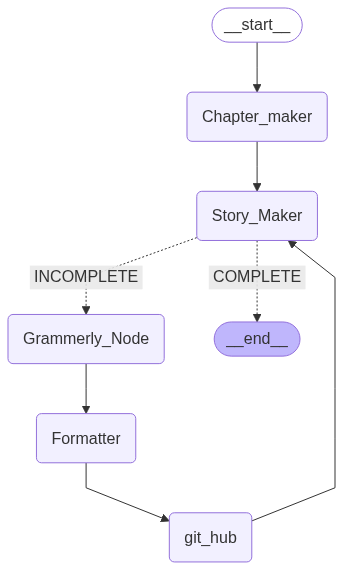

In [42]:
graph

In [ ]:
from langgraph.graph import START, END , StateGraph

def chapter_maker(inp: str) -> str:
    print("Chapter_maker")
    return inp

def grammar_checker(inp: str) -> str:
    print("Check Grammar")
    return inp

def story_maker(inp: str) -> str:
    print("Story_Maker")
    return inp

def formatter(inp: str) -> str:
    print("Formatter")
    return inp

def github(inp: str) -> str:
    print("git_hub")
    return inp

def dummy(inp: str) -> str:
    print("git_hub")
    return inp

# routing function returns arbitrary labels
def check_complete(inp: str) -> str:
    # 50% chance to say we’re done
    return "COMPLETE" if random.random() < 0.5 else "INCOMPLETE"

builder = StateGraph(State)

builder.add_node('Chapter_maker',chapter_maker)
builder.add_node('Grammerly_Node',grammer_checker)
builder.add_node('Story_Maker',story_maker)
builder.add_node('Formatter', formatter)
builder.add_node('git_hub',github)
builder.add_node('dummy',dummy)





builder.add_edge(START,'Chapter_maker')
builder.add_edge('Chapter_maker','Story_Maker')
builder.add_node('tools', ToolNode([chapter_and_story_maker]))
builder.add_conditional_edges('Story_Maker',check_complete,{'COMPLETE': END, 'INCOMPLETE': 'Grammerly_Node', 'Hello': 'dummy'})
builder.add_edge('Grammerly_Node','Formatter')
builder.add_conditional_edges('Grammerly_Node',tools_condition)
builder.add_edge('Formatter','git_hub')
builder.add_edge('git_hub','Story_Maker')

graph =builder.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

In [7]:
from langgraph.graph import START, END , StateGraph

In [13]:
from langgraph.graph import START, END , StateGraph
from langgraph.prebuilt import ToolNode , tools_condition

def chapter_maker(inp: str) -> str:
    print("Chapter_maker")
    return inp

def grammar_checker(inp: str) -> str:
    print("Check Grammar")
    return inp

def story_maker(inp: str) -> str:
    print("Story_Maker")
    return inp

def formatter(inp: str) -> str:
    print("Formatter")
    return inp

def github(inp: str) -> str:
    print("git_hub")
    return inp

def dummy(inp: str) -> str:
    print("git_hub")
    return inp

# routing function returns arbitrary labels
def check_complete(inp: str) -> str:
    # 50% chance to say we’re done
    return "COMPLETE" if random.random() < 0.5 else "INCOMPLETE"

builder = StateGraph(State)

builder.add_node('Chapter_maker',chapter_maker)
builder.add_node('Grammerly_Node',grammar_checker)
builder.add_node('Story_Maker',story_maker)
builder.add_node('Formatter', formatter)
builder.add_node('git_hub',github)
builder.add_node('elobrator',dummy)





builder.add_edge(START,'Chapter_maker')


builder.add_edge('Chapter_maker','Story_Maker')
builder.add_node('tools', ToolNode([chapter_and_story_maker]))
builder.add_conditional_edges('Story_Maker',check_complete,{'COMPLETE': END, 'INCOMPLETE': 'elobrator'})
builder.add_edge('elobrator','Grammerly_Node')
builder.add_edge('Grammerly_Node','Formatter')
builder.add_conditional_edges('Grammerly_Node',tools_condition, {"NEED_TOOLS": 'tools','DONE_WITH_TOOLS':'Formatter'})
builder.add_edge('tools','Grammerly_Node')
builder.add_edge('Formatter','git_hub')
builder.add_edge('git_hub','Story_Maker')

graph =builder.compile()

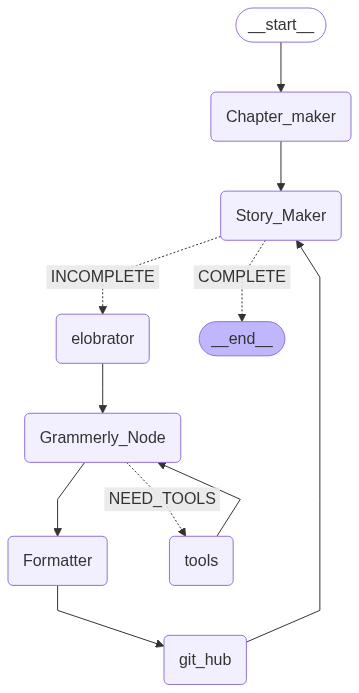

In [14]:
graph